# Proyecto: Predicción de patrones en series de tiempo (univariadas) usando Redes Neuronales Recurrentes

En la presente práctica veremos que la predicción de patrones en series de tiempo de puede realizar mediante un entrenamiento supervisado en donde los features y labels se construyen con los datos de la serie de tiempo.

Veremos que para poder realizar predicciones a largo plazo es necesario que las componentes de cada feature contenga un alto porcentaje de los datos de la serie de tiempo.

Veremos que una red recurrente es capás de generar nuevos features a partir de un "feature raíz".

En esta práctica veremos como lidiar con "outliers".

En esta práctica usaremos una red LSTM y los features que pasaran por la red serán tensores 3D: (m,1,n) [m features, cada uno de tamaño (1,n)]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import seaborn as sns
from scipy import stats

# importamos funciones para construir redes neuronales:
from tensorflow.keras import layers, models, optimizers, regularizers

from sklearn.preprocessing import MinMaxScaler

# Parámetros para graficación
#%matplotlib inline
#plt.rcParams['figure.figsize'] = (15, 5)
#plt.style.use('fast')

In [2]:
# Cargamos datos:
# usamos 'header=None' ya que el dataset viene sin encabezado
df = pd.read_csv('./Data/time_series.csv',header=None)
df

,0,1
0,2017-01-02,236
1,2017-01-03,237
2,2017-01-04,290
3,2017-01-05,221
4,2017-01-07,128
...,...,...
599,2018-11-26,276
600,2018-11-27,220
601,2018-11-28,183
602,2018-11-29,251


In [3]:
# Asignamos nombre a las columnas:
df.columns = ['fechas','unidades']
df

,fechas,unidades
0,2017-01-02,236
1,2017-01-03,237
2,2017-01-04,290
3,2017-01-05,221
4,2017-01-07,128
...,...,...
599,2018-11-26,276
600,2018-11-27,220
601,2018-11-28,183
602,2018-11-29,251


In [4]:
# Extraemos información de las variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 604 entries, 0 to 603
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fechas    604 non-null    object
 1   unidades  604 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.6+ KB


In [5]:
# Vemos que los valores de la columna 'fechas' son del tipo 'object'
# así que las convertimos al tipo 'datetime' para poderlas usar en series de tiempo:
df['fechas']=pd.to_datetime(
    df['fechas'],
    errors = 'coerce',
    format ='%Y/%m/%d'
    )

In [6]:
# Fijamos la columna 'fechas' como indices del dataframe
df = df.set_index(['fechas'])
df

,unidades
fechas,
2017-01-02,236
2017-01-03,237
2017-01-04,290
2017-01-05,221
2017-01-07,128
...,...
2018-11-26,276
2018-11-27,220
2018-11-28,183


In [7]:
# Extraemos las fechas de primer y último registro del dataset:
print('Fecha de primer registro: ', df.index.min())
print('Fecha de último registro: ', df.index.max())

Fecha de primer registro:  2017-01-02 00:00:00
Fecha de último registro:  2018-11-30 00:00:00


In [8]:
# Extraemos el número de registros correspondietes a los años 2017 y 2018 respectivamente:
print('No. de registros del año 2017:', len(df.loc['2017']))
print('No. de registros del año 2018:', len(df.loc['2018']))

No. de registros del año 2017: 315
No. de registros del año 2018: 289


In [9]:
# Extraemos información estadística de los datos:
df.describe()

,unidades
count,604.000000
mean,215.935430
std,75.050304
min,51.000000
25%,171.000000
50%,214.000000
75%,261.250000
max,591.000000


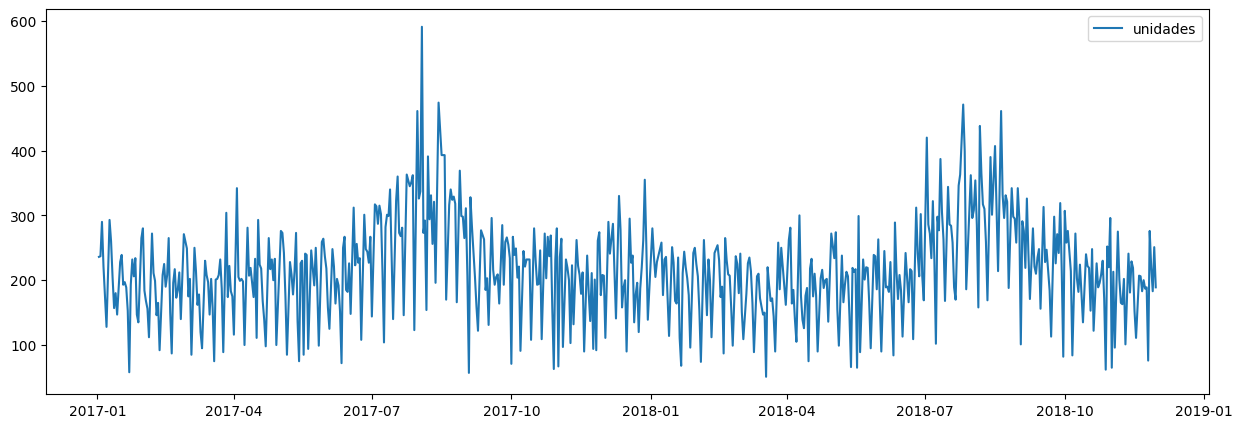

In [10]:
plt.figure(figsize=(15,5))
plt.plot(df['unidades'] , label = 'unidades')
plt.legend()
plt.show()

## Tratamiento de Outliers:

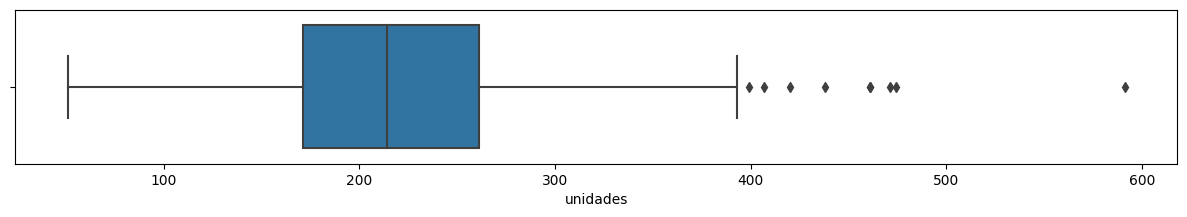

In [11]:
# Usamos un gráfico de caja y bigotes para detectar "outliers" (valores atípicos):
plt.figure(figsize=(15,2))
sns.boxplot(x=df['unidades'])
plt.show()

In [12]:
# Usamos 'zscore' para obtener los múltiplos de desviación estándar a la que distan los
# datos con respecto a la media:
z=np.abs(stats.zscore(df['unidades']))

In [13]:
# Detectamos los outliers como aquellos valores tales que 'z > l_out'
k = 2.4 # radio de outliers
df_out=df[ z > k ]
df_out

,unidades
fechas,
2017-07-31,461
2017-08-03,591
2017-08-14,474
2018-07-02,420
2018-07-26,471
2018-07-27,399
2018-08-06,438
2018-08-16,407
2018-08-20,461


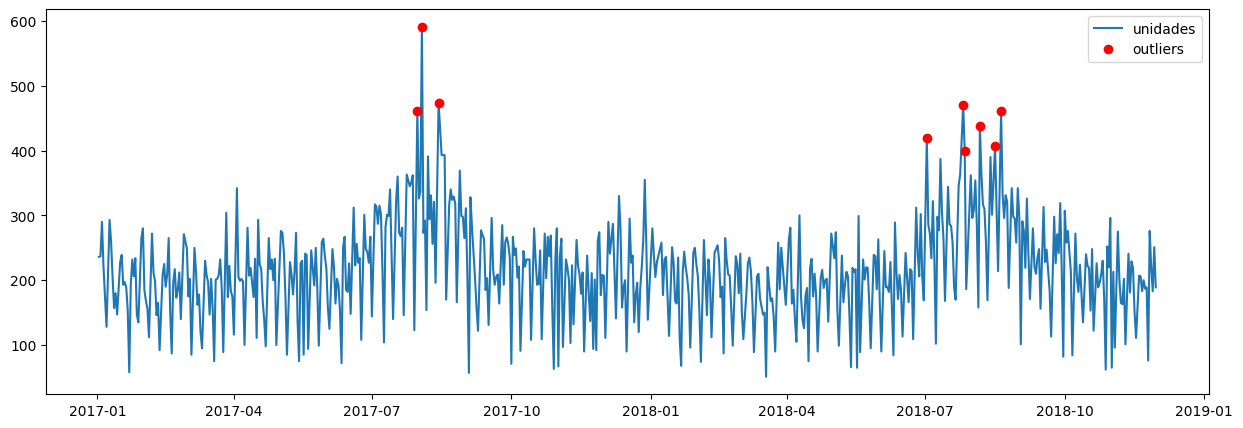

In [14]:
plt.figure(figsize=(15,5))
plt.plot(df['unidades'] , label = 'unidades')
plt.plot(df_out['unidades'],'o',c='r', label = 'outliers')
plt.legend()
plt.show()

In [15]:
# Extraemos los índices de los outliers:
fechas_out = df_out.index
fechas_out

DatetimeIndex(['2017-07-31', '2017-08-03', '2017-08-14', '2018-07-02',
               '2018-07-26', '2018-07-27', '2018-08-06', '2018-08-16',
               '2018-08-20'],
              dtype='datetime64[ns]', name='fechas', freq=None)

### No eliminamos directamente los outliers (ya que se perdería la continuidad de la serie de tiempo), promediamos entre el valor anterior y el posterior:

In [16]:
# Reseteamos los índices del data frame para obtener índices numéricos:
df = df.reset_index()
df

,fechas,unidades
0,2017-01-02,236
1,2017-01-03,237
2,2017-01-04,290
3,2017-01-05,221
4,2017-01-07,128
...,...,...
599,2018-11-26,276
600,2018-11-27,220
601,2018-11-28,183
602,2018-11-29,251


In [17]:
# Extraemos los índices numéricos de los outliers:
Idx_out = df[ df['fechas'].isin(fechas_out) ].index
Idx_out

Int64Index([182, 185, 195, 471, 492, 493, 502, 510, 512], dtype='int64')

In [18]:
df.loc[182,'unidades']

461

In [19]:
# No eliminamos directamente el outlier, promediamos entre el valor anterior y el posterior:
for i in Idx_out:
    df.loc[i,'unidades'] = 0.5*(df.loc[i-1 , 'unidades'] + df.loc[i+1 , 'unidades'])

In [20]:
df[ df['fechas'].isin(fechas_out) ]

,fechas,unidades
182,2017-07-31,224.5
185,2017-08-03,305.0
195,2017-08-14,294.5
471,2018-07-02,227.5
492,2018-07-26,381.0
493,2018-07-27,283.5
502,2018-08-06,261.5
510,2018-08-16,257.5
512,2018-08-20,273.0


In [21]:
# Volvemos a fijar la columna 'fechas' como indices del dataframe
df = df.set_index(['fechas'])
df

,unidades
fechas,
2017-01-02,236.0
2017-01-03,237.0
2017-01-04,290.0
2017-01-05,221.0
2017-01-07,128.0
...,...
2018-11-26,276.0
2018-11-27,220.0
2018-11-28,183.0


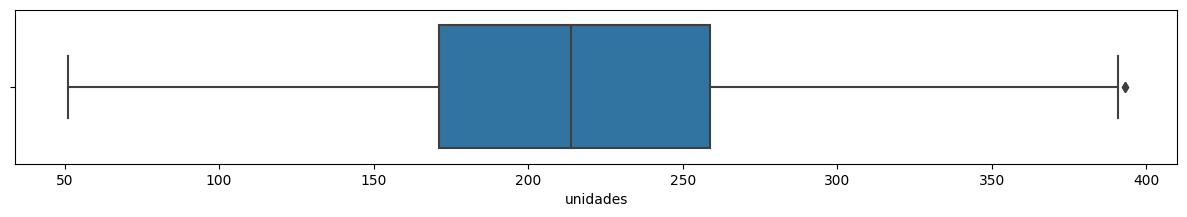

In [22]:
# Usamos un gráfico de caja y bigotes para detectar "outliers" (valores atípicos):
plt.figure(figsize=(15,2))
sns.boxplot(x=df['unidades'])
plt.show()

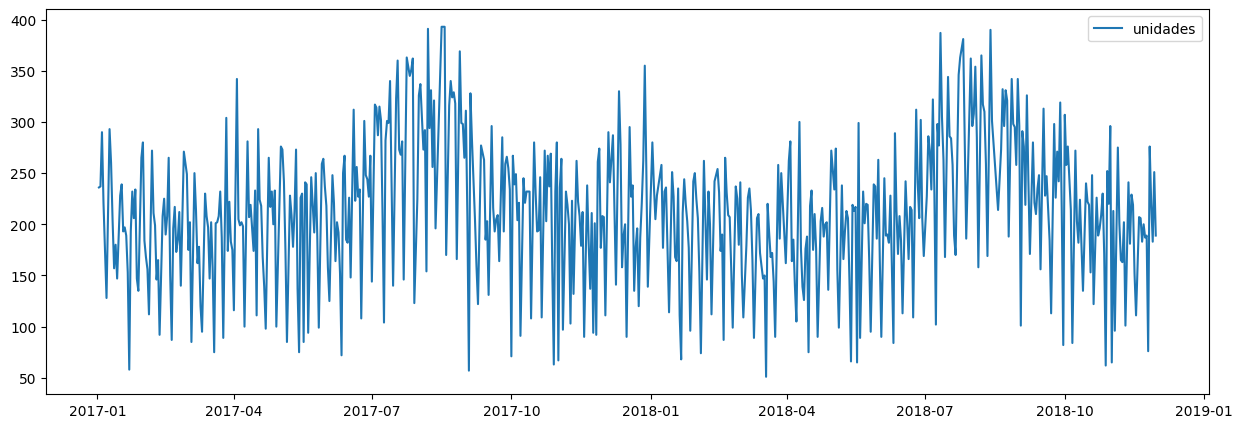

In [23]:
plt.figure(figsize=(15,5))
plt.plot(df['unidades'] , label = 'unidades')
plt.legend()
plt.show()

## Visualizamos información por periodos

In [24]:
# Obtenemos una tabla de promedios mensuales:
meses = df.resample('1M').mean()
meses

,unidades
fechas,
2017-01-31,203.923077
2017-02-28,184.666667
2017-03-31,182.964286
2017-04-30,198.960000
2017-05-31,201.185185
2017-06-30,209.518519
2017-07-31,269.826923
2017-08-31,298.096154
2017-09-30,222.925926


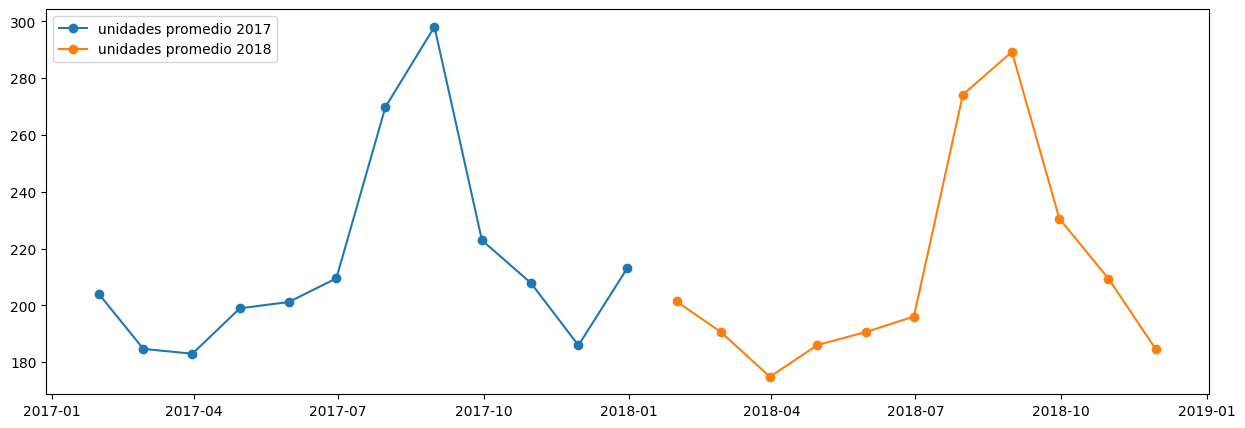

In [25]:
plt.figure(figsize=(15,5))
#plt.plot( meses,'o-' ,label='unidades 2017 y 2018')
plt.plot( meses.loc['2017'], 'o-' ,label='unidades promedio 2017')
plt.plot( meses.loc['2018'], 'o-' , label='unidades promedio 2018')
plt.legend()
plt.show()

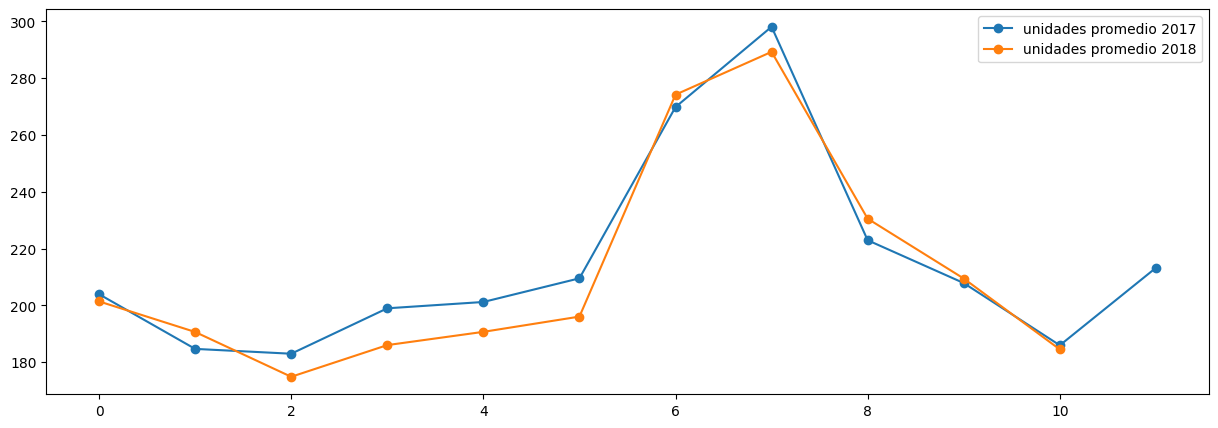

In [26]:
plt.figure(figsize=(15,5))
#plt.plot( meses.values,'o-' ,label='unidades 2017 y 2018')
plt.plot( meses.loc['2017'].values, 'o-' , label='unidades promedio 2017')
plt.plot( meses.loc['2018'].values, 'o-' , label='unidades promedio 2018')
plt.legend()
plt.show()

In [27]:
# Extraemos el registro de ventas diarias en el verano (junio-Agosto) de 2017 y 2018 
verano2017 = df['2017-06-01':'2017-09-01']
verano2018 = df['2018-06-01':'2018-09-01']

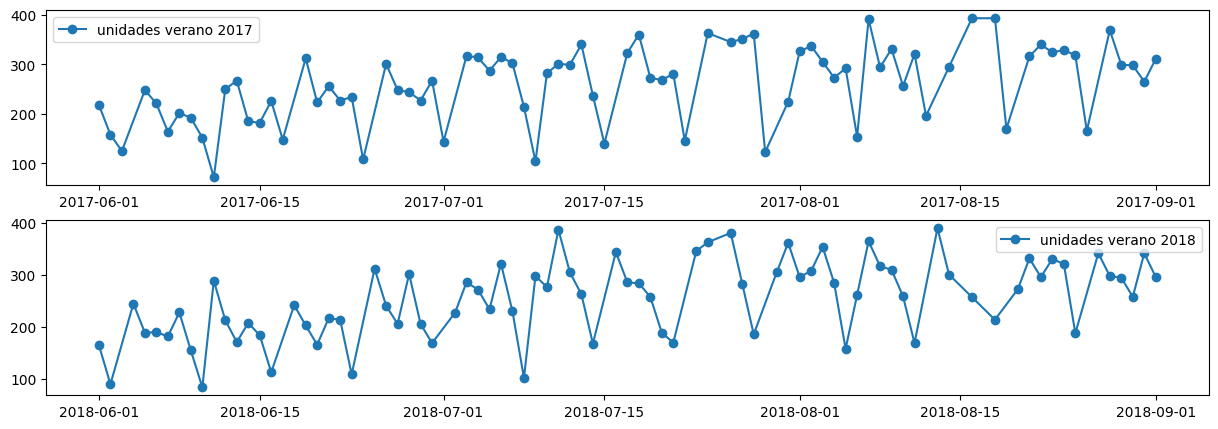

In [28]:
plt.figure(figsize=(15,5))
plt.subplot(2,1,1)
plt.plot( verano2017, 'o-' , label='unidades verano 2017')
plt.legend()

plt.subplot(2,1,2)
plt.plot( verano2018, 'o-' , label='unidades verano 2018')
plt.legend()
plt.show()

## A continuación preparamos los datos que usaremos para entrenar un modelo que realizará pronósticos para la serie de tiempos:

### Como modelo usaremos una Red Neuronal (Feed Forward) cuya capa de salida no tendrá función de activación (tal como en los casos de regresión), sin embargo en las capas internas usaremos la función de activación `ReLu` que toma valores entre [0,+inf] así que reescalaremos los datos entre [0,1].

In [29]:
# Reescalamos los datos entre [0,1] usando la función 'MinMaxScaler':

scaler = MinMaxScaler(feature_range=(0, 1))

scaled_vals = scaler.fit_transform(df)
scaled_vals.shape

(604, 1)

Otra forma de reescalar los datos es mediante la creación de una transformación lineal que lleva [x0,x1]->[y0,y1]:

```
def linear_T(x,x0,x1,y0,y1):
    m = (y1-y0)/(x1-x0)
    return m*(x-x0) + y0
```

## Construimos Features y Labels a partir de la serie de tiempo:

Inicialmente la serie de tiempo es de la forma: [x1, x2, x3, x4, x5, x6, x7, x8, x9, ...]

De dicha serie de tiempos construimos el conunto de features y labels para entrenar un modelo supervisado.

Construimos los features usando los primeros `n` registros y el label correspondiente será el siguiente registro `n+1`:

Por ejmplo:

x1, x2, x3, |x4

x2, x3, x4, |x5

x3, x4, x5, |x6 ...

Feature 1 = [x1, x2, x3]; Label 1 = x4 

Feature 2 = [x2, x3, x4]; Label 2 = x5

Feature 3 = [x3, x4, x5]; Label 3 = x6 

y así susesivamente.

In [30]:
# Definimos la función que creará los features y labels que consumirá la red neuronal:
def split_sequence( n_steps , sequence ):
    N = len(sequence)    
    X, Y = [], []
    for i in range( N ):
        end_Xi = i + n_steps
        if end_Xi > N - 1:
            break
        seq_Xi = sequence[i:end_Xi]
        Yi = sequence[end_Xi]

        X.append(seq_Xi)
        Y.append(Yi)

    return np.array(X), np.array(Y)  

In [31]:
p_d = 0.012 #<-- porcentaje de datos que se tomaran para construir cada feature

# No. de componentes para cada feature:
n_comp = round( p_d*len(df) )

print('Cada feature consta de',n_comp,'componentes (días registrados) que corresponde a un',p_d*100,'% de los datos')

Cada feature consta de 7 componentes (días registrados) que corresponde a un 1.2 % de los datos


### Obs: Entre más grande sea el número de componentes de cada feature podremos hacer predicciones a largo plazo. Hay que tener cuidado que el número de componentes de cada feature sea más pequeño el número de datos de validación

In [32]:
# Construimos features y labels:
x_features , y_labels = split_sequence(n_comp , scaled_vals)

In [33]:
x_features.shape

(597, 7, 1)

In [34]:
x_features = x_features[:,:,0]

In [35]:
x_features.shape

(597, 7)

In [36]:
# Redimensionamos features como tensores 3D:
x_features = x_features.reshape( x_features.shape[0],1,x_features.shape[1] )

x_features.shape


(597, 1, 7)

In [37]:
# Visualizamos los features en un Data Frame
pd.DataFrame(x_features[:,0,:])

,0,1,2,3,4,5,6
0,0.540936,0.543860,0.698830,0.497076,0.225146,0.707602,0.611111
1,0.543860,0.698830,0.497076,0.225146,0.707602,0.611111,0.447368
2,0.698830,0.497076,0.225146,0.707602,0.611111,0.447368,0.309942
3,0.497076,0.225146,0.707602,0.611111,0.447368,0.309942,0.377193
4,0.225146,0.707602,0.611111,0.447368,0.309942,0.377193,0.280702
...,...,...,...,...,...,...,...
592,0.456140,0.453216,0.385965,0.435673,0.397661,0.403509,0.073099
593,0.453216,0.385965,0.435673,0.397661,0.403509,0.073099,0.657895
594,0.385965,0.435673,0.397661,0.403509,0.073099,0.657895,0.494152
595,0.435673,0.397661,0.403509,0.073099,0.657895,0.494152,0.385965


In [38]:
# Visualizamos los labels en un Data Frame
pd.DataFrame(y_labels)

,0
0,0.447368
1,0.309942
2,0.377193
3,0.280702
4,0.517544
...,...
592,0.657895
593,0.494152
594,0.385965
595,0.584795


## Construcción de datos de entrenamiento y validación:

Debido a que en las series de tiempo, el orden sí importa, debemos particionar los datos conservando el orden.

In [39]:
p_val = p_d + 0.038 # <-- porcentaje de datos de validación (debe ser mayor que el número de componetes en cada feature)
print('Tomamos un',p_val*100,'% de los datos para validación,')
print('correspondiente a los últimos',round( p_val*len(df) ),'días registrados')

if p_val > p_d:
    # índice límite para extraer datos de entrenamiento:
    j = len(df) - round( p_val*len(df) )

    # Features de entrenamiento y validación
    x_train = x_features[:j , :]
    x_val = x_features[j: , :]

    # Labels de entrenamiento y validación
    y_train = y_labels[:j]
    y_val = y_labels[j:]

else:
    print("Error! El número de componetes de cada feature debe ser menor que los datos de validación")
    stop

Tomamos un 5.0 % de los datos para validación,
correspondiente a los últimos 30 días registrados


In [40]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(574, 1, 7)
(23, 1, 7)
(574, 1)
(23, 1)


In [41]:
# Extraemos la dimensión de cada feature:
dim_feature = x_train[0].shape
dim_feature

(1, 7)

## Construimos la Red Neuronal:

In [42]:
def build_model(dim_feature , lr):
    # Construimos arquitectura de la red:
    model = models.Sequential()

    # Número de neuronas en cada capa:
    nn = 15
        
    # Capa 1 (entrada)
    #model.add( layers.Dense(nn, activation='relu', input_shape=dim_feature, kernel_regularizer=regularizers.l2(0.001) ) )
    model.add( layers.LSTM(nn, activation='relu', input_shape=dim_feature) )

    # Capa 2
    model.add( layers.Dense(nn, activation='relu' ))
    
    # Capa de salida (una sóla neurona con función de activación 'tanh')
    #model.add( layers.Dense(1, activation='tanh') )
    
    # Capa de salida (una sóla neurona sin función de activación)
    model.add( layers.Dense(1) )

    # visualzamos la arquitecura de la red:
    # model.summary()

    # optimizador:
    optim_meth = optimizers.Nadam(learning_rate=lr)

    # compilamos la red:
    model.compile(
        optimizer= optim_meth,
        loss='mse',  # <-- Función de costo a minimizar: mean square error (para problemas de regresión)
        #metrics='mae'# <-- Métrica para evaluar entrenamiento: mean absolute error
        )

    return model

In [43]:
# ================= Parámetros que controlan la convergencia de la red =====================
# learning rate:
lr = 0.001

n_epochs = 200

n_batch_size = n_comp
n_batch_size
# ===========================================================================================

7

In [ ]:
# Declaramos la red neuronal:
model = build_model(dim_feature , lr)

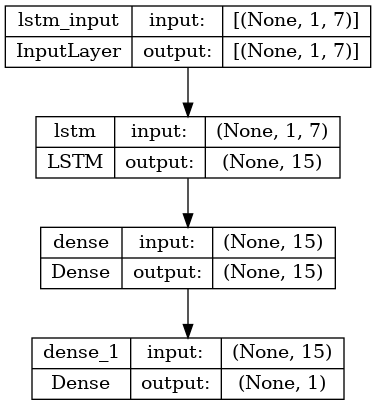

In [45]:
# Generamos un grafico sobre la arquitectura de la red:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='modelo.png', show_shapes = True)

In [46]:
# Entrenamos la red:   
training = model.fit(
    x_train,
    y_train,
    epochs=n_epochs,
    batch_size =n_batch_size,
    validation_data = (x_val,y_val),
    verbose=0 # 1 --> muestra el proceso de entrenamiento
)

In [47]:
# Extraemos las curvas de 'loss' y 'accuracy' para los datos de entrenamiento y validacion: 
loss_train_curve = training.history['loss']
loss_valid_curve = training.history['val_loss']

#accu_train_curve = training.history['mae']
#accu_valid_curve = training.history['val_mae']

Text(0.5, 0, 'epoch')

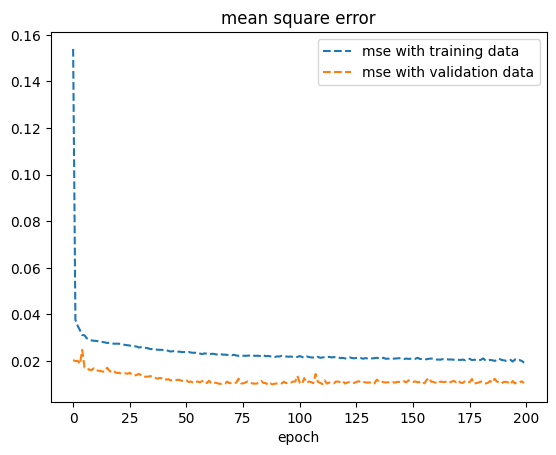

In [48]:
# Graficamos curvas:

# Eje x:
epoch = range( n_epochs )

#plt.subplot(1,2,1)
plt.plot(epoch, loss_train_curve, '--', label='mse with training data')
plt.plot(epoch, loss_valid_curve, '--', label='mse with validation data')
plt.legend()
plt.title('mean square error')
plt.xlabel('epoch')

#plt.subplot(1,2,2)
#plt.plot(epoch, accu_train_curve, label='mae with training data')
#plt.plot(epoch, accu_valid_curve, label='mae with validation data')
#plt.legend()
#plt.title('mean absolute error')
#plt.xlabel('epoch')
#plt.show()

In [49]:
model.evaluate(x_val, y_val)

1/1 [==============================] - 0s 29ms/step - loss: 0.0105


0.010546444915235043

In [50]:
# Hacemos predicciones con el modelo entrenado: 
y_pred=model.predict(x_val)

1/1 [==============================] - 0s 162ms/step


In [51]:
y_pred.shape

(23, 1)

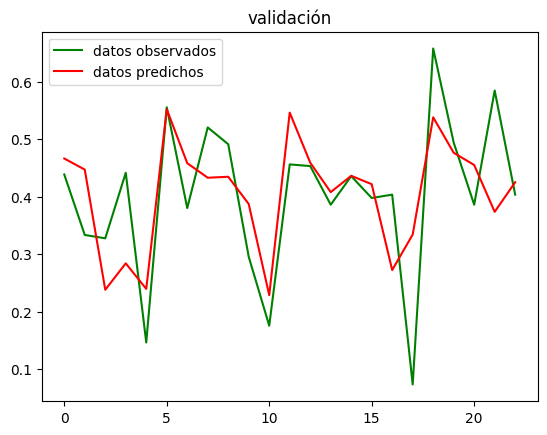

In [52]:
plt.plot(range(len(y_val)) ,y_val,c='g',label = 'datos observados')
plt.plot(range(len(y_pred[:,0])),y_pred[:,0],c='r', label = 'datos predichos')
plt.title('validación')
plt.legend()
plt.show()

## Pronóstico de ventas futuras:

Para predecir valores a futuro, debemos construir el "feature raíz" a partir del cual se construiran los valores futuros.
El "feature raíz" se construye con los últimos registros de la serie de tiempo.

Usaremos los registros de los últimos días de noviembre 2018 para predecir la primer semana de diciembre 2018

In [53]:
# Extraemos las fechas de primer y último registro del dataset:
print('Fecha de primer registro: ', df.index.min())
print('Fecha de último registro: ', df.index.max())

Fecha de primer registro:  2017-01-02 00:00:00
Fecha de último registro:  2018-11-30 00:00:00


In [54]:
# Extraemos los últimos 'n_last' registros para construir el "feature raíz" a partir del cual
# se construirán las predicciones

n_last = df.shape[0] - n_comp - 1

df_last_days = df.iloc[ n_last :  ] #df['2018-11-22':'2018-11-30']
df_last_days

,unidades
fechas,
2018-11-23,187.0
2018-11-24,189.0
2018-11-25,76.0
2018-11-26,276.0
2018-11-27,220.0
2018-11-28,183.0
2018-11-29,251.0
2018-11-30,189.0


In [55]:
# Reescalamos los datos entre [0,1]:
scaled_vals_last = scaler.fit_transform(df_last_days)
scaled_vals_last.shape

(8, 1)

In [56]:
# Extraemos features y labels de la serie anterior:
x_features2 , y_labels2 = split_sequence(n_comp,scaled_vals_last)

In [57]:
x_features2.shape

(1, 7, 1)

In [58]:
x_features2 = x_features2[:,:,0]

In [59]:
x_features2.shape

(1, 7)

In [60]:
# Redimensionamos features como tensores 3D:
x_features2 = x_features2.reshape( x_features2.shape[0],1,x_features2.shape[1] )

x_features2.shape

(1, 1, 7)

In [61]:
# Visualizamos los features en un Data Frame
pd.DataFrame(x_features2[:,0,:])

,0,1,2,3,4,5,6
0,0.555,0.565,0.0,1.0,0.72,0.535,0.875


In [62]:
# Del conjunto anterior 'x_features2' tomamos el último renglón, 
# pués corresponde a los datos de la última semana de Noviembre  
x_test = x_features2[-1]
x_test.shape

(1, 7)

In [75]:
# Iniciamos la predicción de la serie de tiempo

# No. de días a predecir:
n_days = 7

# Redimensionamos feature para que pase por la red entrenada:
xi = x_test.reshape(1,1, x_test.shape[1] )

list_pred=[]
for i in range(n_days):

    # Obtenemos la predicción del feature 'xi':
    yi = model.predict(xi)
    yi = yi.reshape(1,1,1)
    #print(yi)

    # Construimos feature para la siguiente predicción:
    xi = np.concatenate([xi[:,:,1:],yi], axis=2)
    #print(xi)

    # Vamos guardando predicciones en la lista 'list_pred':
    list_pred.append( yi[0][0] )

# Guardamos la lista en un arreglo de numpy:
y_new = np.array(list_pred)
y_new


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


array([[0.54944724],
       [0.0817364 ],
       [0.93073064],
       [0.80223393],
       [0.70322174],
       [0.48928916],
       [0.5089758 ]], dtype=float32)

In [76]:
x_test.shape

(1, 7)

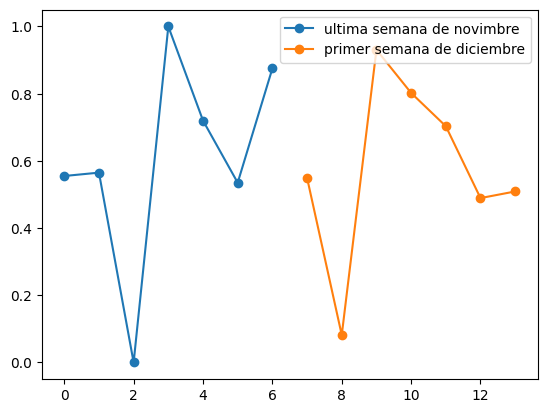

In [77]:
p = x_test.shape[1]
q = len(y_new)

plt.plot( range(p), x_test[0,:],'o-',label='ultima semana de novimbre')
plt.plot( range(p,p+q), y_new,'o-',label='primer semana de diciembre')
plt.legend()
plt.show()

## Debido a que las predicciones se hicieron con datos reescalados en [0,1], invertimos el reescalado para obtener las predicciones en el dominio de los datos reales 


In [78]:
# Redimensionamos 'y_new' como array 2D para aplicarle la transformación inversa del reescalado:
y_new = y_new.reshape( q,1 )

# Obtenemos el pronóstico de la serie de tiempo real:
y_pronostic = scaler.inverse_transform(y_new)
y_pronostic

array([[185.88945],
       [ 92.34728],
       [262.14615],
       [236.4468 ],
       [216.64436],
       [173.85783],
       [177.79517]], dtype=float32)

In [79]:
p = len(df_last_days)
q = len(y_pronostic)

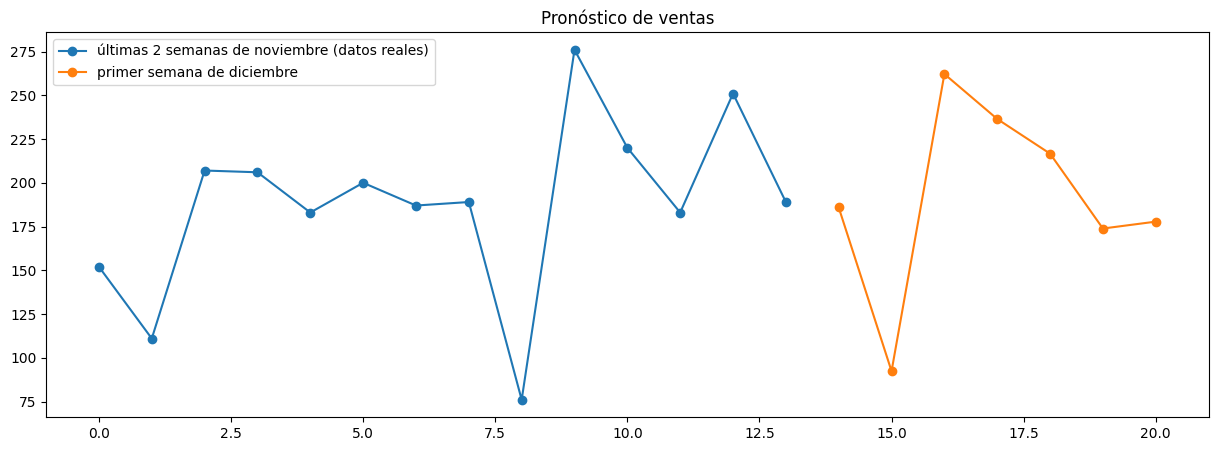

In [80]:
df_last_days = df['2018-11-16':'2018-11-30']

p = len(df_last_days)
q = len(y_pronostic)

plt.figure(figsize=(15,5))
plt.plot( range(p), df_last_days,'o-',label='últimas 2 semanas de noviembre (datos reales)')
plt.plot( range(p,p+q), y_pronostic,'o-',label='primer semana de diciembre')
plt.title('Pronóstico de ventas')
plt.legend()
plt.show()